### Data Importation

In [ ]:
import pandas as pd
train_df = pd.read_csv('/content/train_dataset_final.csv')
test_df = pd.read_csv('/content/test_dataset_final.csv')
validation_df = pd.read_csv('/content/valid_dataset_final.csv')

In [ ]:
train_df.columns

Index(['Unnamed: 0', 'ID', 'Tweet', 'anger', 'anticipation', 'disgust', 'fear',
       'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust',
       'text', 'processPost_text', 'tokens', 'stop_words_free',
       'disambiguated', 'dediacritized'],
      dtype='object')

### **Data preparation**

In [ ]:
import numpy as np
MAX_LENGTH = 256
X_train_input_ids = np.zeros((len(train_df), MAX_LENGTH))
X_train_attn_masks = np.zeros((len(train_df), MAX_LENGTH))

X_test_input_ids = np.zeros((len(test_df), MAX_LENGTH))
X_test_attn_masks = np.zeros((len(test_df), MAX_LENGTH))

X_validation_input_ids = np.zeros((len(validation_df), MAX_LENGTH))
X_validation_attn_masks = np.zeros((len(validation_df), MAX_LENGTH))

In [ ]:
from tqdm import tqdm

def generate_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['text'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [ ]:
!pip install transformers -q
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('hatemnoaman/bert-base-arabic-finetuned-emotion')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 114.1 MB/s eta 0:00:00


In [ ]:
X_train_input_ids, X_train_attn_masks = generate_data(train_df, X_train_input_ids, X_train_attn_masks, tokenizer) 

X_test_input_ids, X_test_attn_masks = generate_data(test_df, X_test_input_ids, X_test_attn_masks, tokenizer) 

X_validation_input_ids, X_validation_attn_masks = generate_data(validation_df, X_validation_input_ids, X_validation_attn_masks, tokenizer) 

2227it [00:05, 440.11it/s] 
1488it [00:00, 2564.96it/s]
573it [00:00, 2481.46it/s]


In [ ]:
train_labels = np.zeros((len(train_df), 11))
test_labels = np.zeros((len(test_df), 11))
validation_labels = np.zeros((len(validation_df), 11))

In [ ]:
labels_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']  
train_labels = train_df[labels_names].values.astype('int32')
test_labels = test_df[labels_names].values.astype('int32')
validation_labels = validation_df[labels_names].values.astype('int32')

In [ ]:
import tensorflow as tf
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_input_ids, X_train_attn_masks, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_input_ids, X_test_attn_masks, test_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_validation_input_ids, X_validation_attn_masks, validation_labels))

In [ ]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

In [ ]:
BATCH_SIZE = 16
train_dataset = train_dataset.map(SentimentDatasetMapFunction) # converting to required format for tensorflow dataset 
train_dataset = train_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True) # batch size, drop any left out tensor
validation_dataset = validation_dataset.map(SentimentDatasetMapFunction)
validation_dataset = validation_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.map(SentimentDatasetMapFunction)
test_dataset = test_dataset.shuffle(10000).batch(BATCH_SIZE, drop_remainder=False)

### **Model**

In [ ]:
from transformers import TFBertModel
model = TFBertModel.from_pretrained('hatemnoaman/bert-base-arabic-finetuned-emotion', from_pt=True) # bert base model with pretrained weights

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['classifier.bias', 'classifier.weight', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

In [ ]:
# bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
base = model.bert(input_ids, attention_mask=attn_masks)
bert_embds = base.pooler_output

In [ ]:
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(11, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

In [ ]:
emotion_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
emotion_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  110617344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

### **Train**

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=2e-5) #1e-3
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
emotion_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [ ]:
NUM_EPOCHS=10
with tf.device('/GPU:0'):
  history = emotion_model.fit(
      train_dataset,
      validation_data=validation_dataset,
      epochs=NUM_EPOCHS
  )

Epoch 1/10
139/139 [==============================] - 163s 919ms/step - loss: 5.0050 - accuracy: 0.4119 - val_loss: 5.6445 - val_accuracy: 0.5446
Epoch 2/10
139/139 [==============================] - 126s 910ms/step - loss: 5.6978 - accuracy: 0.4892 - val_loss: 7.1792 - val_accuracy: 0.3982
Epoch 3/10
139/139 [==============================] - 126s 910ms/step - loss: 6.7092 - accuracy: 0.4843 - val_loss: 9.1326 - val_accuracy: 0.3589
Epoch 4/10
139/139 [==============================] - 126s 910ms/step - loss: 7.9513 - accuracy: 0.5157 - val_loss: 9.9065 - val_accuracy: 0.3518
Epoch 5/10
139/139 [==============================] - 126s 909ms/step - loss: 9.3156 - accuracy: 0.5130 - val_loss: 11.7162 - val_accuracy: 0.3768
Epoch 6/10
139/139 [==============================] - 126s 908ms/step - loss: 10.4920 - accuracy: 0.5193 - val_loss: 12.7357 - val_accuracy: 0.4018
Epoch 7/10
139/139 [==============================] - 126s 907ms/step - loss: 11.7943 - accuracy: 0.5108 - val_loss: 14.3

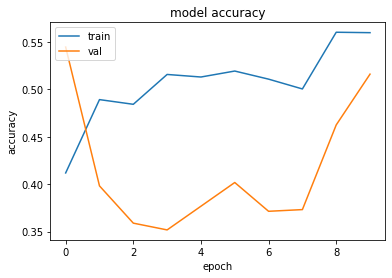

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

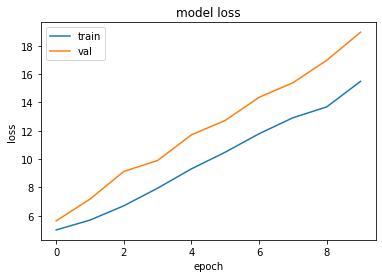

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
dict_ = emotion_model.evaluate(test_dataset, verbose=0, return_dict=True)
dict_

{'loss': 19.11763572692871, 'accuracy': 0.5456989407539368}

## Adding LSTM layer

In [ ]:
import tensorflow as tf
from transformers import TFBertModel

# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

# Load the BERT model
bert_model = TFBertModel.from_pretrained('hatemnoaman/bert-base-arabic-finetuned-emotion', from_pt=True) 

# Pass the inputs to BERT model to get the embeddings
bert_output = bert_model(input_ids, attention_mask=attn_masks)

# Add LSTM layer after the BERT layer
lstm_output = tf.keras.layers.LSTM(128, name='lstm_layer')(bert_output.last_hidden_state)

# Add intermediate and output layers
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(lstm_output)
output_layer = tf.keras.layers.Dense(11, activation='softmax', name='output_layer')(intermediate_layer)

# Create the model
emotion_model2 = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)

# Print model summary
emotion_model2.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['classifier.bias', 'classifier.weight', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model_4 (TFBertModel)  TFBaseModelOutputWi  110617344   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                         

In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
emotion_model2.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [ ]:
NUM_EPOCHS=6
with tf.device('/GPU:0'):
  history2 = emotion_model2.fit(
      train_dataset,
      validation_data=validation_dataset,
      epochs=NUM_EPOCHS
  )

Epoch 1/6


139/139 [==============================] - 175s 1s/step - loss: 4.5967 - accuracy: 0.5229 - val_loss: 4.7072 - val_accuracy: 0.5696
Epoch 2/6
139/139 [==============================] - 137s 987ms/step - loss: 4.6107 - accuracy: 0.5787 - val_loss: 5.2721 - val_accuracy: 0.5536
Epoch 3/6
139/139 [==============================] - 138s 990ms/step - loss: 4.6622 - accuracy: 0.5868 - val_loss: 5.6299 - val_accuracy: 0.6071
Epoch 4/6
139/139 [==============================] - 137s 989ms/step - loss: 5.0373 - accuracy: 0.5850 - val_loss: 6.3342 - val_accuracy: 0.5893
Epoch 5/6
139/139 [==============================] - 137s 988ms/step - loss: 5.1608 - accuracy: 0.6380 - val_loss: 6.1815 - val_accuracy: 0.5732
Epoch 6/6
139/139 [==============================] - 137s 987ms/step - loss: 5.4231 - accuracy: 0.5962 - val_loss: 6.4569 - val_accuracy: 0.4036


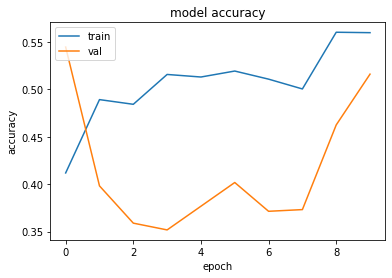

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

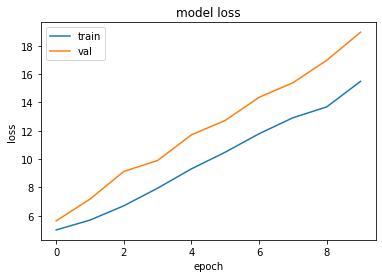

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
dict_ = emotion_model2.evaluate(test_dataset, verbose=0, return_dict=True)
dict_

{'loss': 6.6276092529296875, 'accuracy': 0.4052419364452362}